In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms, datasets, models

In [2]:
PATH = './data/'
RANDOM_STATE = 29

In [3]:
def load_data(transform_train=transforms.ToTensor(), transform_test=transforms.ToTensor(), 
              download=True, verbose=True):
    
    train_dataset = datasets.CIFAR100(root=PATH,
                                      transform=transform_train,
                                      download=download)

    test_dataset = datasets.CIFAR100(root=PATH,
                                     train=False,
                                     transform=transform_test,
                                     download=download)
    
    if verbose:
        print(f'Размер тренировочного датасета:\t{len(train_dataset)}')
        print(f'Размер тестового датасета:\t{len(test_dataset)}')
    
    torch.random.manual_seed(RANDOM_STATE)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=128,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=128,
                                              shuffle=False)
    
    return train_loader, test_loader

In [4]:
aug_transformers_ = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

aug_transformers = transforms.Compose([
    aug_transformers_,
    transforms.ToTensor()
])

In [5]:
train_loader, test_loader = load_data(transform_train=aug_transformers)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data/
Files already downloaded and verified
Размер тренировочного датасета:	50000
Размер тестового датасета:	10000


In [6]:
classes = ['beaver', 'dolphin', 'otter', 'seal', 'whale', 'aquarium fish', 'flatfish', 
           'ray', 'shark', 'trout', 'orchids', 'poppies', 'roses', 'sunflowers',
           'tulips', 'bottles', 'bowls', 'cans', 'cups', 'plates', 'apples',
           'mushrooms', 'oranges', 'pears', 'sweet peppers', 'clock',
           'computer keyboard', 'lamp', 'telephone', 'television', 'bed',  
           'chair', 'couch', 'table', 'wardrobe', 'bee',  'beetle',  'butterfly',
           'caterpillar', 'cockroach', 'bear', 'leopard', 'lion', 'tiger', 'wolf',
           'bridge', 'castle', 'house', 'road', 'skyscraper', 'cloud', 'forest', 
           'mountain', 'plain', 'sea', 'camel', 'cattle', 'chimpanzee', 'elephant', 
           'kangaroo', 'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'crab',
           'lobster', 'snail', 'spider', 'worm', 'baby', 'boy', 'girl', 'man', 
           'woman', 'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', 'hamster', 
           'mouse', 'rabbit', 'shrew', 'squirrel', 'maple', 'oak', 'palm', 'pine',
           'willow', 'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train', 
           'lawn-mower',  'rocket',  'streetcar',  'tank',  'tractor']

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
image_size = next(iter(train_loader))[0][0].shape
image_size

torch.Size([3, 32, 32])

In [9]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        torch.random.manual_seed(RANDOM_STATE)
        
        self.conv1 = nn.Conv2d(image_size[0], 32, 3, padding=1) 
        self.maxpool = nn.MaxPool2d(2) 
        self.bn1 = nn.BatchNorm2d(32, track_running_stats=False)
        self.dp = nn.Dropout(0.25)
        self.dp2d = nn.Dropout2d(0.25)
    
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) 
        self.bn2 = nn.BatchNorm2d(64, track_running_stats=False)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) 
        self.bn3 = nn.BatchNorm2d(128, track_running_stats=False)
    
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128*4*4, 512)
        self.bn4 = nn.BatchNorm1d(512, track_running_stats=False)
        
        self.fc2 = nn.Linear(512, len(classes))
        
    def forward(self, x):
        
        # Свёрточные слои
        x = self.conv1(x) # 3x32x32 -> 32x32x32
        x = self.maxpool(x) # 32x32x32 -> 32x16x16
        # x = self.dp2d(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x) # 32x16x16 -> 64x16x16
        x = self.maxpool(x) # 64x16x16 -> 64x8x8
        x = self.dp2d(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        x = self.conv3(x) # 64x8x8 -> 128x8x8
        x = self.maxpool(x) # 128x8x8 -> 128x4x4
        # x = self.dp2d(x)
        x = self.bn3(x)
        x = F.relu(x)
        
        # Полносвязные слои
        x = self.flatten(x) # 128x4x4 -> 128*4*4
        x = self.fc1(x)
        x = self.dp(x)
        x = self.bn4(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        return x
    
    def predict(self, x):
        x = self.forward(x)
        x = F.softmax(x, dim=1)
        return x

In [10]:
summary(MyNet().to(device), input_size=image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
       BatchNorm2d-3           [-1, 32, 16, 16]              64
            Conv2d-4           [-1, 64, 16, 16]          18,496
         MaxPool2d-5             [-1, 64, 8, 8]               0
         Dropout2d-6             [-1, 64, 8, 8]               0
       BatchNorm2d-7             [-1, 64, 8, 8]             128
            Conv2d-8            [-1, 128, 8, 8]          73,856
         MaxPool2d-9            [-1, 128, 4, 4]               0
      BatchNorm2d-10            [-1, 128, 4, 4]             256
          Flatten-11                 [-1, 2048]               0
           Linear-12                  [-1, 512]       1,049,088
          Dropout-13                  [-1, 512]               0
      BatchNorm1d-14                  [

In [11]:
def train_nn(net, train_loader, test_loader, lr=1e-3, epochs=5, verbose=True, parameters=None):

    torch.backends.cudnn.deterministic = True
    criterion = nn.CrossEntropyLoss()
    if parameters is None:
        parameters = net.parameters()
    optimizer = torch.optim.Adam(parameters, lr=lr)
    
    metrics_train_global = np.array([])
    metrics_test_global = np.array([])

    for epoch in range(epochs):
        start_time = time.time()
        metrics_train = np.array([])
        metrics_test = np.array([])
        losses_train = np.array([])
        losses_test = np.array([])

        for i, data in enumerate(train_loader):
            net.train()
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses_train = np.append(losses_train, loss.item())
            net.eval()
            metrics_train = np.append(metrics_train, (labels == outputs.argmax(axis=1)).sum().cpu() / len(labels))
        
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                losses_test = np.append(losses_test, loss.item())
                metrics_test = np.append(metrics_test, (labels == outputs.argmax(axis=1)).sum().cpu() / len(labels))    
        
        if verbose:
            print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                  f'Train loss: {losses_train.mean():.4f}. '\
                  f'Test loss: {losses_test.mean():.4f}. '\
                  f'Train accuracy: {metrics_train.mean():.4f}. '\
                  f'Test accuracy: {metrics_test.mean():.4f}. '
                  f'Time: {int(time.time() - start_time)} s')
        
        metrics_train_global = np.append(metrics_train_global, metrics_train.mean())
        metrics_test_global = np.append(metrics_test_global, metrics_test.mean())
    print('Training is finished!')
    return metrics_train_global, metrics_test_global

In [12]:
mynet = MyNet().to(device)
mynet_train, mynet_test = train_nn(mynet, train_loader, test_loader, epochs=20)

Epoch [1/20]. Train loss: 3.4908. Test loss: 2.7407. Train accuracy: 0.1802. Test accuracy: 0.3128. Time: 37 s
Epoch [2/20]. Train loss: 2.6911. Test loss: 2.2925. Train accuracy: 0.3233. Test accuracy: 0.4027. Time: 37 s
Epoch [3/20]. Train loss: 2.3664. Test loss: 2.1174. Train accuracy: 0.3876. Test accuracy: 0.4480. Time: 37 s
Epoch [4/20]. Train loss: 2.1604. Test loss: 2.0218. Train accuracy: 0.4330. Test accuracy: 0.4672. Time: 36 s
Epoch [5/20]. Train loss: 2.0097. Test loss: 1.9527. Train accuracy: 0.4677. Test accuracy: 0.4844. Time: 37 s
Epoch [6/20]. Train loss: 1.8951. Test loss: 1.8994. Train accuracy: 0.4933. Test accuracy: 0.5010. Time: 36 s
Epoch [7/20]. Train loss: 1.8054. Test loss: 1.8557. Train accuracy: 0.5148. Test accuracy: 0.5202. Time: 36 s
Epoch [8/20]. Train loss: 1.7046. Test loss: 1.8368. Train accuracy: 0.5365. Test accuracy: 0.5217. Time: 36 s
Epoch [9/20]. Train loss: 1.6215. Test loss: 1.8229. Train accuracy: 0.5551. Test accuracy: 0.5303. Time: 36 s
E

In [13]:
resnet_transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [14]:
resnet_aug_transformer = transforms.Compose([
    aug_transformers_,
    resnet_transformer
])

In [20]:
def train_resnet(transformer_train, epochs=5, verbose=1):
    resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    
    for param in resnet50.parameters():
        param.requires_grad = False
        
    resnet_train_loader, resnet_test_loader = load_data(transform_train=transformer_train, 
                                                        transform_test=resnet_transformer,
                                                        download=False, verbose=False)
    
    torch.random.manual_seed(RANDOM_STATE)
    resnet50.fc = nn.Linear(2048, 100)

    params_to_update = []
    for param in resnet50.parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    
    resnet50 = resnet50.to(device)
    resnet_train, resnet_test = train_nn(resnet50, resnet_train_loader, resnet_test_loader, 
                                         epochs=epochs, verbose=verbose, parameters=params_to_update)
    return resnet50, resnet_train, resnet_test

In [21]:
resnet50, resnet_train, resnet_test = train_resnet(resnet_transformer, epochs=20)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch [1/20]. Train loss: 2.5938. Test loss: 1.9313. Train accuracy: 0.4165. Test accuracy: 0.5254. Time: 269 s
Epoch [2/20]. Train loss: 1.6756. Test loss: 1.6810. Train accuracy: 0.5764. Test accuracy: 0.5638. Time: 268 s
Epoch [3/20]. Train loss: 1.4175. Test loss: 1.5882. Train accuracy: 0.6312. Test accuracy: 0.5783. Time: 267 s
Epoch [4/20]. Train loss: 1.2683. Test loss: 1.5232. Train accuracy: 0.6652. Test accuracy: 0.5895. Time: 267 s
Epoch [5/20]. Train loss: 1.1544. Test loss: 1.4843. Train accuracy: 0.6946. Test accuracy: 0.6001. Time: 267 s
Epoch [6/20]. Train loss: 1.0654. Test loss: 1.4691. Train accuracy: 0.7171. Test accuracy: 0.6010. Time: 267 s
Epoch [7/20]. Train loss: 0.9915. Test loss: 1.4597. Train accuracy: 0.7381. Test accuracy: 0.6058. Time: 267 s
Epoch [8/20]. Train loss: 0.9309. Test loss: 1.4600. Train accuracy: 0.7532. Test accuracy: 0.6037. Time: 267 s
Epoch [9/20]. Train loss: 0.8767. Test loss: 1.4456. Train accuracy: 0.7687. Test accuracy: 0.6047. Time

In [22]:
resnet50_aug, resnet_aug_train, resnet_aug_test = train_resnet(resnet_aug_transformer, epochs=20)

Epoch [1/20]. Train loss: 2.8360. Test loss: 2.0525. Train accuracy: 0.3620. Test accuracy: 0.5068. Time: 293 s
Epoch [2/20]. Train loss: 2.0108. Test loss: 1.7701. Train accuracy: 0.4949. Test accuracy: 0.5489. Time: 292 s
Epoch [3/20]. Train loss: 1.7872. Test loss: 1.6509. Train accuracy: 0.5374. Test accuracy: 0.5720. Time: 292 s
Epoch [4/20]. Train loss: 1.6631. Test loss: 1.5672. Train accuracy: 0.5614. Test accuracy: 0.5854. Time: 292 s
Epoch [5/20]. Train loss: 1.5796. Test loss: 1.5358. Train accuracy: 0.5794. Test accuracy: 0.5935. Time: 292 s
Epoch [6/20]. Train loss: 1.5217. Test loss: 1.4970. Train accuracy: 0.5930. Test accuracy: 0.5983. Time: 292 s
Epoch [7/20]. Train loss: 1.4782. Test loss: 1.4747. Train accuracy: 0.6004. Test accuracy: 0.6032. Time: 292 s
Epoch [8/20]. Train loss: 1.4290. Test loss: 1.4804. Train accuracy: 0.6101. Test accuracy: 0.5988. Time: 292 s
Epoch [9/20]. Train loss: 1.3972. Test loss: 1.4507. Train accuracy: 0.6189. Test accuracy: 0.6057. Time

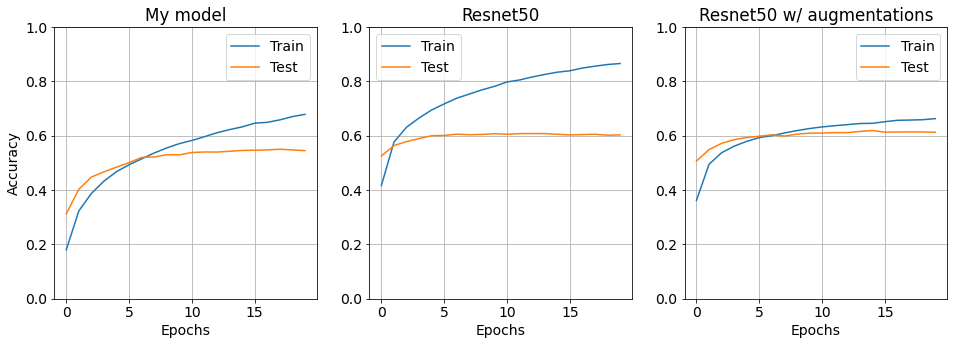

In [23]:
plt.figure(figsize=(16, 5))
plt.rcParams.update({'font.size': 14})

plt.subplot(1, 3, 1)
plt.plot(range(len(mynet_train)), mynet_train, label='Train')
plt.plot(range(len(mynet_test)), mynet_test, label='Test')
plt.title('My model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim([0, 1])
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(len(resnet_train)), resnet_train, label='Train')
plt.plot(range(len(resnet_test)), resnet_test, label='Test')
plt.title('Resnet50')
plt.xlabel('Epochs')
plt.ylim([0, 1])
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(len(resnet_aug_train)), resnet_aug_train, label='Train')
plt.plot(range(len(resnet_aug_test)), resnet_aug_test, label='Test')
plt.title('Resnet50 w/ augmentations')
plt.xlabel('Epochs')
plt.ylim([0, 1])
plt.grid()
plt.legend()

plt.show()

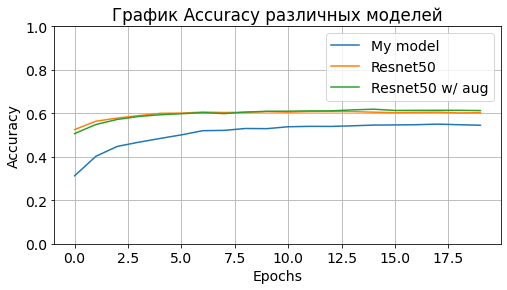

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(mynet_test)), mynet_test, label='My model')
plt.plot(range(len(resnet_test)), resnet_test, label='Resnet50')
plt.plot(range(len(resnet_aug_test)), resnet_aug_test, label='Resnet50 w/ aug')
plt.title('График Accuracy различных моделей')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()